In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#발전기명, 년월일, 설비용량(MW)	01시	02시	03시	04시	05시	06시	07시	08시	09시	10시	11시	12시	13시	14시	15시	16시	17시	18시	19시	20시	21시	22시	23시	24시

dataset1 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_세종.csv', encoding='cp949')
dataset2 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_안산.csv', encoding='cp949')
dataset3 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_영암.csv', encoding='cp949')

dataset1.head()

,발전기명,년월일,설비용량(MW),1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,세종시폐기물매립장태양광,2017-01-01,1.628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,742080.0,334440.0,87240.0,2880.0,4320.0,0.0,0.0,0.0,0.0,0.0
1,세종시폐기물매립장태양광,2017-01-02,1.628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,606360.0,501120.0,158280.0,2760.0,3360.0,0.0,0.0,0.0,0.0,0.0
2,세종시폐기물매립장태양광,2017-01-03,1.628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,881040.0,557040.0,128640.0,2280.0,3000.0,0.0,0.0,0.0,0.0,0.0
3,세종시폐기물매립장태양광,2017-01-04,1.628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,677280.0,502320.0,112080.0,1800.0,2760.0,0.0,0.0,0.0,0.0,0.0
4,세종시폐기물매립장태양광,2017-01-05,1.628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,259560.0,138840.0,45000.0,2520.0,2880.0,0.0,0.0,0.0,0.0,0.0


### * nan 값 0으로 대체

In [3]:
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("Before : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

dataset1, dataset2, dataset3 = dataset1.fillna(0), dataset2.fillna(0), dataset3.fillna(0)
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("After : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)


Before :  33 5 1
After :  0 0 0


In [4]:
new_dataset1, new_dataset2, new_dataset3 = [], [], []

for i in range(len(dataset1)):
    new_dataset1.extend(dataset1.iloc[i,3:])

for i in range(len(dataset2)):
    new_dataset2.extend(dataset2.iloc[i,3:])

for i in range(len(dataset3)):
    new_dataset3.extend(dataset3.iloc[i,3:])
    
len(new_dataset1), len(new_dataset2), len(new_dataset3)

(40776, 40896, 40896)

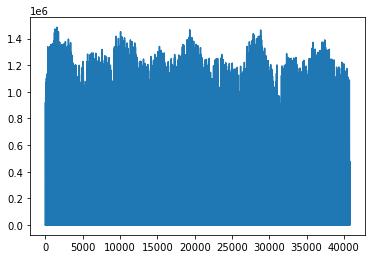

In [5]:
plt.plot(new_dataset1)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from keras.engine import input_layer
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

def local_model_generate(model): #초기 모델 생성
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


In [8]:
num_locals = 2

local1 = np.array(new_dataset1).reshape(-1, 1)
local2 = np.array(new_dataset2).reshape(-1, 1)
local3 = np.array(new_dataset3).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))

for i in range(1,num_locals):
    globals()['local{}'.format(i)] = scaler.fit_transform(globals()['local{}'.format(i)])
    print(len(globals()['local{}'.format(i)]))
    
train_size = int(len(local1)*0.80)
test_size = len(local1) - train_size

for i in range(1,num_locals):
    globals()['train_{}'.format(i)], globals()['test_{}'.format(i)] = globals()['local{}'.format(i)][0:train_size, :], globals()['local{}'.format(i)][train_size:len(local1),:]
    print(len(globals()['train_{}'.format(i)]), len(globals()['test_{}'.format(i)]))

40776
32620 8156


In [9]:
look_back = 1
local_epoch = 300
local_batch = 10

for i in range(1, num_locals):
    trainX, trainY = create_dataset(globals()['train_{}'.format(i)], look_back)
    testX, testY = create_dataset(globals()['test_{}'.format(i)], look_back)
    print(len(trainX), len(trainY), len(testX),  len(testY))
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    globals()['model{}'.format(i)] = Sequential()
    local_model_generate(globals()['model{}'.format(i)])
    history = globals()['model{}'.format(i)].fit(trainX, trainY, validation_data=(testX, testY),
                                       epochs=local_epoch, batch_size=local_batch, verbose=1)

32618 32618 8154 8154
Epoch 1/300
3262/3262 [==============================] - 6s 1ms/step - loss: 0.0166 - val_loss: 0.0099
Epoch 2/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 3/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 4/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 5/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 6/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 7/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 8/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 9/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 10/300
3262/3262 [===========================

3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 158/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 159/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 160/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 161/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 162/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 163/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 164/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 165/300
3262/3262 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 166/300
3262/3262 [==============================] - 4s 1ms/ste

In [10]:
for i in range(1, num_locals):
    trainPredict = globals()['model{}'.format(i)].predict(trainX)
    testPredict = globals()['model{}'.format(i)].predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    globals()['trainScore_{}'.format(i)] = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))#RMSE
    globals()['testScore_{}'.format(i)] = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

255/255 [==============================] - 0s 624us/step


In [1]:
train_mse = model1.evaluate(trainX, trainY[0], verbose=0)
test_mse = model1.evaluate(testX, testY[0], verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train', marker='o')
plt.plot(history.history['val_loss'], label='test', marker='o')
plt.xlabel('epoch')
plt.ylim(0.0092,0.010)
plt.legend()
plt.show()

NameError: name 'model1' is not defined

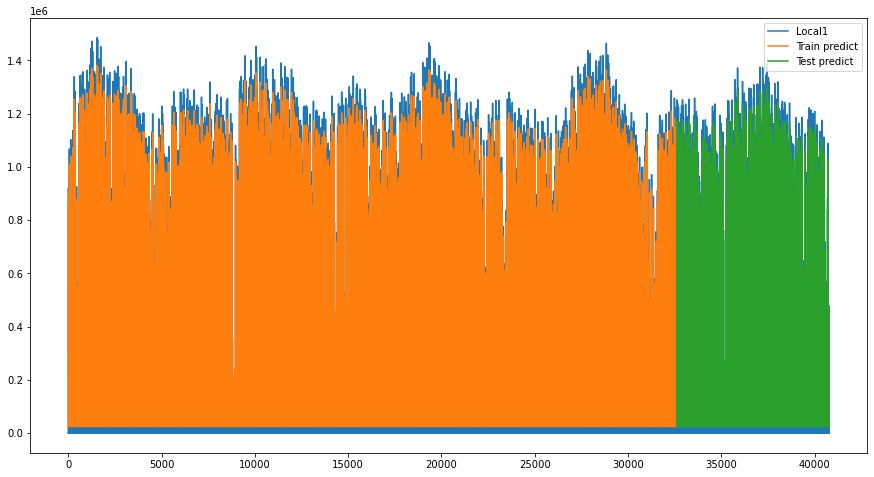

In [12]:
#plot-------------------------------------------------
trainPredict_plot = np.empty_like(local1)
trainPredict_plot[:,:] = np.nan
trainPredict_plot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredict_plot = np.empty_like(local1)
testPredict_plot[:,:] = np.nan
testPredict_plot[len(trainPredict)+(look_back*2)+1:len(local1)-1, :] = testPredict

plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(local1), label='Local1')
plt.plot(trainPredict_plot, label='Train predict')
plt.plot(testPredict_plot, label='Test predict')
plt.legend()
plt.show()

In [13]:
trainScore_1, testScore_1, trainScore_1/len(trainY[0]), testScore_1/len(testY[0])

(151530.4325520788, 145934.60162927158, 4.6456077181948245, 17.897302137511844)

In [14]:
(153501.65531338903, 148159.70787192753, 5.619272076486768, 11.011498169596992)


(153501.65531338903, 148159.70787192753, 5.619272076486768, 11.011498169596992)